In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
achmatim_indonesian_wayang_traditional_puppet_show_path = kagglehub.dataset_download('achmatim/indonesian-wayang-traditional-puppet-show')

print('Data source import complete.')


100%|██████████| 765M/765M [00:35<00:00, 22.3MB/s]

Extracting files...


Data source import complete.


In [61]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2, InceptionV3, ResNet101V2

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# ETL (Extract, Transform, Load) Process

## Extract Data

In [3]:
# Path to the directory containing the dataset
data_dir = achmatim_indonesian_wayang_traditional_puppet_show_path + '/labeled-indonesian-wayang'

# Get the list of all subdirectories (each representing a class)
classes = os.listdir(data_dir)
print(classes)

['kresna', 'arjuna', 'baladewa', 'patih_sabrang', 'anoman', 'bima', 'cakil', 'togog', 'duryudana', 'karna', 'puntadewa', 'nakula_sadewa', 'sengkuni', 'buta', 'petruk', 'gatotkaca', 'dursasana', 'gareng', 'bagong', 'semar', 'abimanyu', 'durna']


In [4]:
# Initialize a counter to store the number of images per class
class_counts = Counter()

# Iterate over each class directory
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in each class directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the distribution of images per class
print("Data Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Data Distribution:
kresna: 368 images
arjuna: 400 images
baladewa: 400 images
patih_sabrang: 272 images
anoman: 352 images
bima: 336 images
cakil: 304 images
togog: 192 images
duryudana: 304 images
karna: 256 images
puntadewa: 272 images
nakula_sadewa: 192 images
sengkuni: 256 images
buta: 368 images
petruk: 320 images
gatotkaca: 320 images
dursasana: 288 images
gareng: 192 images
bagong: 384 images
semar: 352 images
abimanyu: 256 images
durna: 192 images


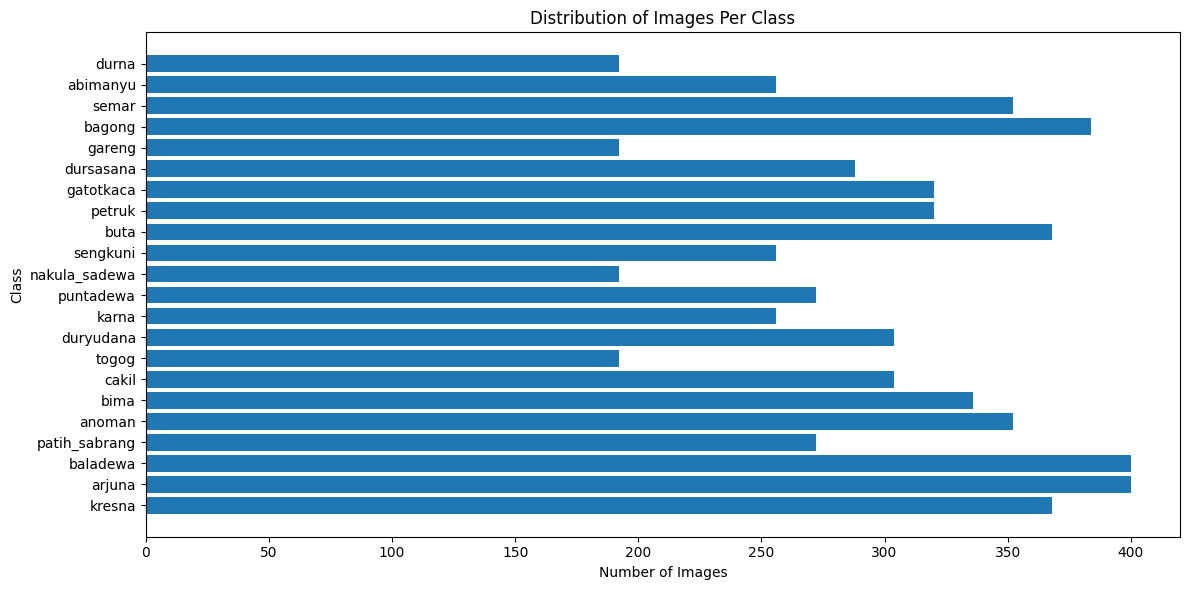

In [5]:
# Plot the distribution using a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.ylabel('Class')
plt.xlabel('Number of Images')
plt.title('Distribution of Images Per Class')
plt.tight_layout()
plt.show()


In [6]:
# Show images extension
extensions = set()
for root, dirs, files in os.walk(data_dir):
    for file in files:
        _, ext = os.path.splitext(file)
        extensions.add(ext)

print(extensions)

{'.jpg', '.JPG'}


In [7]:
# Define paths
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/validation'
test_dir = '/kaggle/working//data/test'

In [8]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [9]:
# Split data into train, validation, and test sets
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    # Create class subdirectories in train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split into train and temp (validation + test) by 7:3 ratio
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    # Split temp into validation and test by 50% each
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

In [10]:
# Check the number of images each directory after splitting
num_train_images_per_class = {}
num_val_images_per_class = {}
num_test_images_per_class = {}

for class_name in classes:
    num_train_images_per_class[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))
    num_val_images_per_class[class_name] = len(os.listdir(os.path.join(val_dir, class_name)))
    num_test_images_per_class[class_name] = len(os.listdir(os.path.join(test_dir, class_name)))

In [11]:
# Print the results
print("Number of training images per class:", num_train_images_per_class)
print("Number of validation images per class:", num_val_images_per_class)
print("Number of test images per class:", num_test_images_per_class)

Number of training images per class: {'kresna': 257, 'arjuna': 280, 'baladewa': 280, 'patih_sabrang': 190, 'anoman': 246, 'bima': 235, 'cakil': 212, 'togog': 134, 'duryudana': 212, 'karna': 179, 'puntadewa': 190, 'nakula_sadewa': 134, 'sengkuni': 179, 'buta': 257, 'petruk': 224, 'gatotkaca': 224, 'dursasana': 201, 'gareng': 134, 'bagong': 268, 'semar': 246, 'abimanyu': 179, 'durna': 134}
Number of validation images per class: {'kresna': 55, 'arjuna': 60, 'baladewa': 60, 'patih_sabrang': 41, 'anoman': 53, 'bima': 50, 'cakil': 46, 'togog': 29, 'duryudana': 46, 'karna': 38, 'puntadewa': 41, 'nakula_sadewa': 29, 'sengkuni': 38, 'buta': 55, 'petruk': 48, 'gatotkaca': 48, 'dursasana': 43, 'gareng': 29, 'bagong': 58, 'semar': 53, 'abimanyu': 38, 'durna': 29}
Number of test images per class: {'kresna': 56, 'arjuna': 60, 'baladewa': 60, 'patih_sabrang': 41, 'anoman': 53, 'bima': 51, 'cakil': 46, 'togog': 29, 'duryudana': 46, 'karna': 39, 'puntadewa': 41, 'nakula_sadewa': 29, 'sengkuni': 39, 'bu

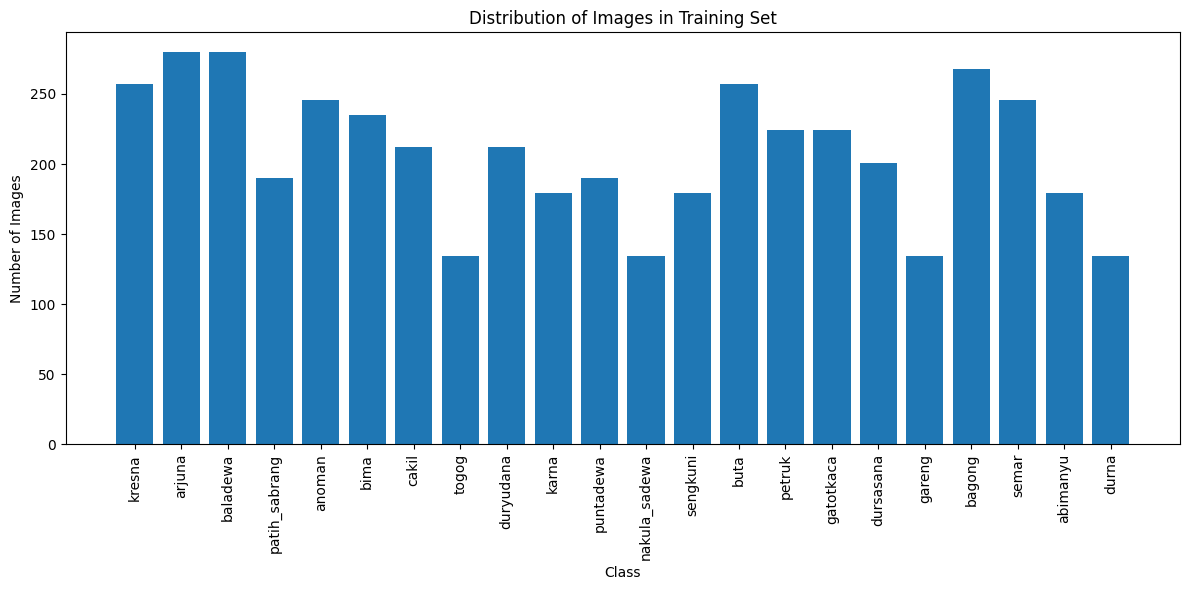

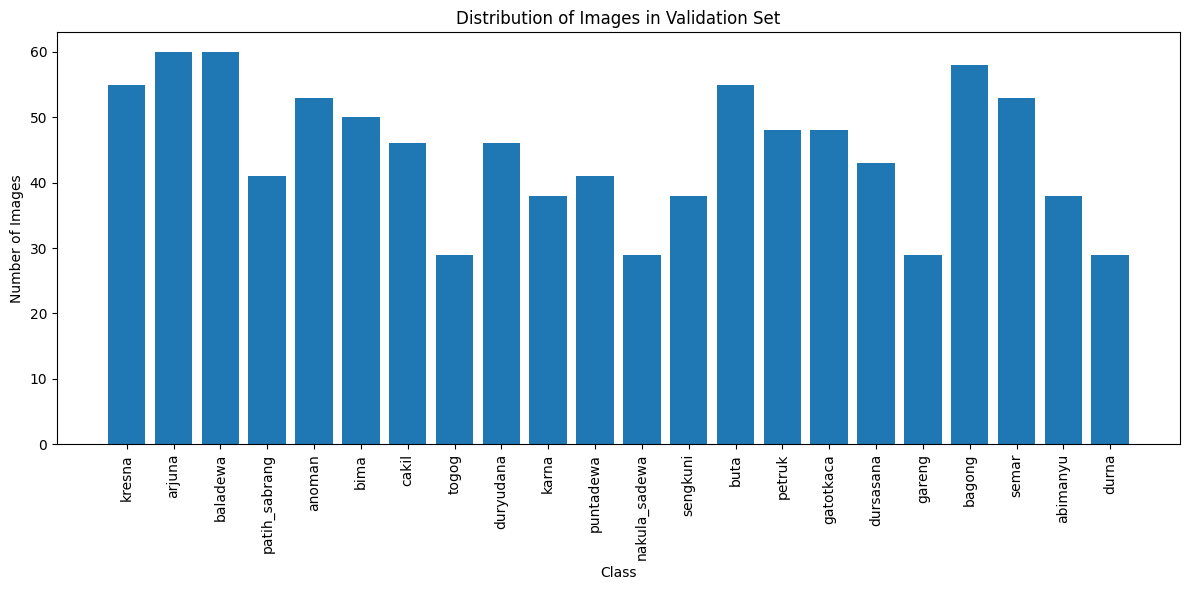

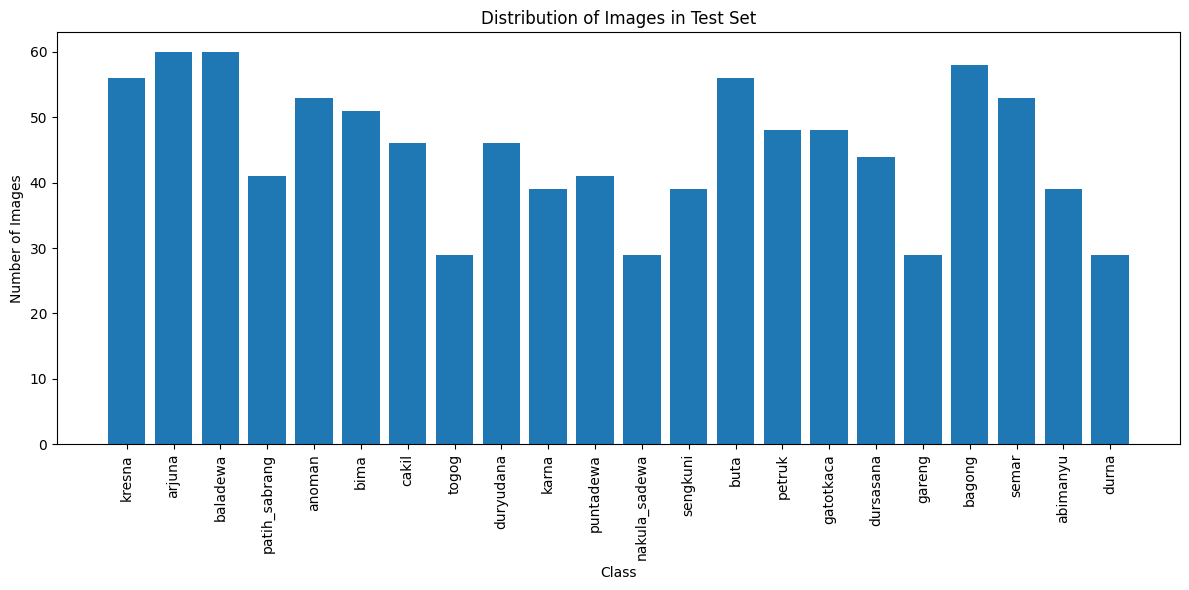

In [12]:
 Function to count images in each class directory
def count_images_in_directory(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Count images in each split
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)

# Plot the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot distributions for each dataset split
plot_distribution(train_counts, 'Distribution of Images in Training Set')
plot_distribution(val_counts, 'Distribution of Images in Validation Set')
plot_distribution(test_counts, 'Distribution of Images in Test Set')

## Transform & Load Data

In [13]:
# Augment the images for training
train_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

In [14]:
val_test_generator = ImageDataGenerator(
    rescale=1. / 255
)

In [15]:
train_generator = train_generator.flow_from_directory(
    '/kaggle/working/data/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 4595 images belonging to 22 classes.


In [16]:
# Assuming you have a directory structure for your validation dataset
validation_generator = val_test_generator.flow_from_directory(
    '/kaggle/working/data/validation',  # Path to validation data
    target_size=(224, 224),  # Resize images to this size
    batch_size=64,  # Number of images per batch
    class_mode='categorical',  # Type of label arrays
    shuffle=False
)

Found 987 images belonging to 22 classes.


In [18]:
# Create test generator
test_generator = val_test_generator.flow_from_directory(
    '/kaggle/working/data/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

Found 994 images belonging to 22 classes.


# ML Model Development

In [19]:
# Function to create a model based on a pre-trained architecture
def create_pretrained_model(base_model, num_classes, freeze_layers=50):
    # Freeze the first few layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 22

In [21]:
# Load the pre-trained models
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [22]:
efficientnet_b2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
resnet_101v2 = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [41]:
# View the total layers
print("Total layers in InceptionV3:", len(inception_v3.layers))
print("Total layers in EfficientNetB2:", len(efficientnet_b2.layers))
print("Total layers in ResNet101V2:", len(resnet_101v2.layers))

Total layers in InceptionV3: 311
Total layers in EfficientNetB2: 340
Total layers in ResNet101V2: 377


In [43]:
# Create models using the loaded architectures
models = [
    create_pretrained_model(efficientnet_b2, num_classes),
    create_pretrained_model(inception_v3, num_classes),
    create_pretrained_model(resnet_101v2, num_classes)
]

In [44]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [45]:
# Train Machine Learning Models
history = []
for model in models:
    history.append(model.fit(
        train_generator,
        batch_size=32,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]))

    print(f"Model {models.index(model) + 1} training complete.")

    model.save(f'model_{models.index(model) + 1}.h5')

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8462 - loss: 0.7226 - val_accuracy: 0.8835 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9513 - loss: 0.1927 - val_accuracy: 0.9737 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9634 - loss: 0.1350 - val_accuracy: 0.9564 - val_loss: 0.1718 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9771 - loss: 0.0927 - val_accuracy: 0.9149 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9791 - loss: 0.0818 - val_accuracy: 0.9544 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9779 - loss: 0.0711 - val_accuracy: 0.9949 - val_loss: 0.0160 - learning_rate: 2.0000e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9913 - loss: 0.0293 - val_accur

Model 1 training complete.
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.4188 - loss: 2.0326 - val_accuracy: 0.1915 - val_loss: 3.1142 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8304 - loss: 0.5348 - val_accuracy: 0.3445 - val_loss: 3.9115 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9237 - loss: 0.2558 - val_accuracy: 0.3191 - val_loss: 6.5472 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9365 - loss: 0.2395 - val_accuracy: 0.5350 - val_loss: 3.5982 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9665 - loss: 0.1104 - val_accuracy: 0.9797 - val_loss: 0.0648 - learning_rate: 2.0000e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9906 - loss: 0.0298 - val_accuracy: 0.9949 - val_loss: 0.0192 - learning_rate: 2.0000e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.

Model 2 training complete.
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.2767 - loss: 2.4074 - val_accuracy: 0.0608 - val_loss: 2263.7786 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6379 - loss: 1.0638 - val_accuracy: 0.0608 - val_loss: 215.6943 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7556 - loss: 0.7231 - val_accuracy: 0.2330 - val_loss: 7.4009 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8521 - loss: 0.4335 - val_accuracy: 0.3465 - val_loss: 3.8578 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8941 - loss: 0.3069 - val_accuracy: 0.2898 - val_loss: 6.7646 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9061 - loss: 0.2763 - val_accuracy: 0.5613 - val_loss: 1.9805 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9

Model 3 training complete.


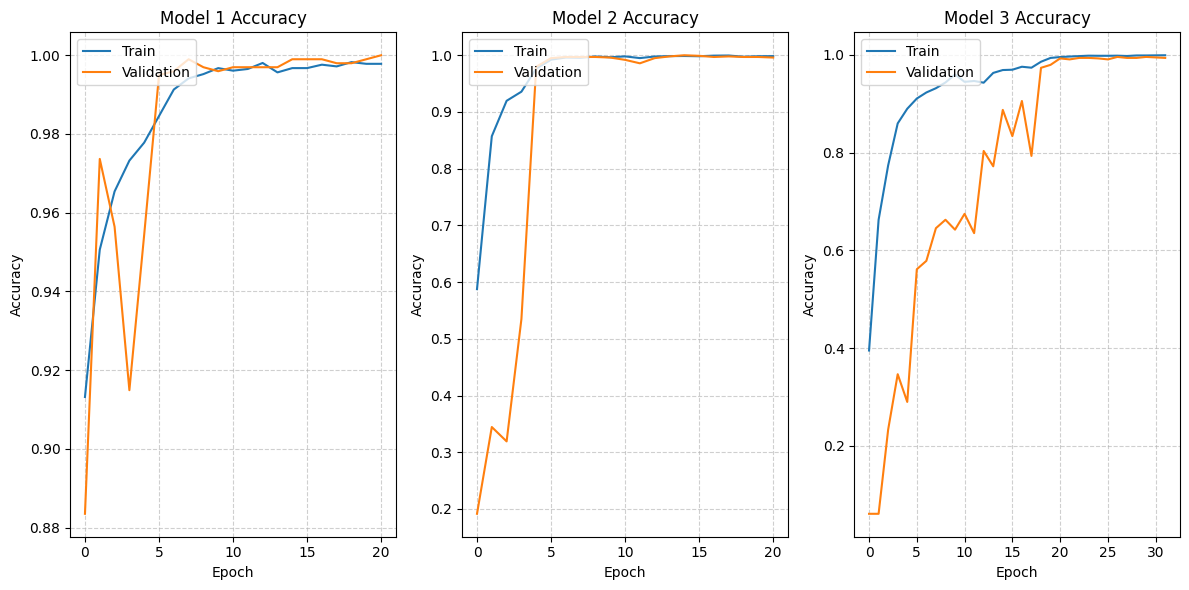

In [53]:
import matplotlib.pyplot as plt # Make sure you have this import

# Assuming 'history' is a list where each element is the History object from model.fit()
# And 'models' is a list of the models (though 'models' isn't strictly needed for plotting history)

num_models = len(history) # Get the number of models/histories

# --- Plot Training & Validation Accuracy for all models in one figure ---
plt.figure(figsize=(4 * num_models, 6)) # Adjust figure width based on number of models

for i, hist in enumerate(history):
    # Create subplot for the current model
    plt.subplot(1, num_models, i + 1) # num_rows, num_cols, plot_number

    # Plot accuracy history
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Validation')

    plt.title(f'Model {i+1} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6) # Add a simple grid for better readability

# Adjust layout to prevent titles/labels overlapping
plt.tight_layout()
# Show the figure containing all accuracy plots
plt.show()

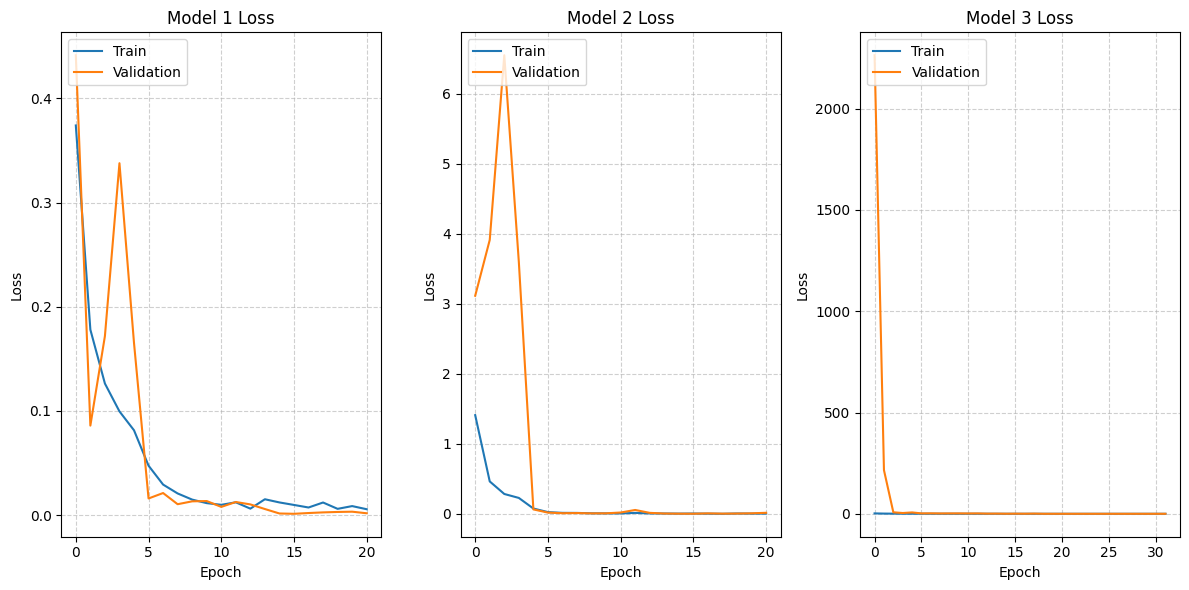

In [54]:
# --- Plot Training & Validation Loss for all models in a separate figure ---
plt.figure(figsize=(4 * num_models, 6)) # Use a different figure for loss

for i, hist in enumerate(history):
    # Create subplot for the current model
    plt.subplot(1, num_models, i + 1) # num_rows, num_cols, plot_number

    # Plot loss history
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Validation')

    plt.title(f'Model {i+1} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6) # Add a simple grid

# Adjust layout for the loss plots
plt.tight_layout()
# Show the figure containing all loss plots
plt.show()

In [55]:
# List to store evaluation results for each model
evaluation_results = []

print("--- Evaluating each model on the test set ---")

for i, model in enumerate(models):
    print(f"\nEvaluating Model {i+1}...")
    results = model.evaluate(test_generator, verbose=1)
    metric_names = model.metrics_names

    # Store the results in a dictionary for clarity
    model_results = {'model_index': i + 1}
    for name, value in zip(metric_names, results):
        model_results[name] = value

    evaluation_results.append(model_results)

    print(f"Model {i+1} Results: Loss = {model_results['loss']:.4f}", end="")
    # Print other metrics (skip loss as it's already printed)
    for name in metric_names[1:]:
         print(f", {name.capitalize()} = {model_results[name]:.4f}", end="")
    print() # Newline after printing metrics

print("\n--- Evaluation Complete ---")

# You can then print a summary of all results
print("\n--- Summary of Test Set Evaluation Results ---")
for result in evaluation_results:
     print(f"Model {result['model_index']}:", end="")
     for name, value in result.items():
         if name != 'model_index':
             print(f" {name.capitalize()}: {value:.4f}", end="")
     print() # Newline for the next model

print("-" * 30)

# Make predictions with each model
predictions_list = []
print("\n--- Making predictions for ensemble ---")
for i, model in enumerate(models):
    print(f"Making predictions with Model {i+1}...")
    # test_generator.reset()

    predictions = model.predict(test_generator, verbose=1) # verbose=1 shows progress
    predictions_list.append(predictions)
    print(f"Finished predictions for Model {i+1}. Shape: {predictions.shape}")

--- Evaluating each model on the test set ---

Evaluating Model 1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 949ms/step - accuracy: 0.9997 - loss: 6.1148e-04
Model 1 Results: Loss = 0.0016, Compile_metrics = 0.9990

Evaluating Model 2...
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 739ms/step - accuracy: 0.9977 - loss: 0.0050
Model 2 Results: Loss = 0.0079, Compile_metrics = 0.9960

Evaluating Model 3...
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 716ms/step - accuracy: 0.9955 - loss: 0.0116
Model 3 Results: Loss = 0.0080, Compile_metrics = 0.9980

--- Evaluation Complete ---

--- Summary of Test Set Evaluation Results ---
Model 1: Loss: 0.0016 Compile_metrics: 0.9990
Model 2: Loss: 0.0079 Compile_metrics: 0.9960
Model 3: Loss: 0.0080 Compile_metrics: 0.9980
------------------------------

--- Making predictions for ensemble ---
Making predictions with Model 1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 834ms/step
Finished predictions for Model 1. Shape: (994, 22)
Making predictions with Model 2...
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 6


--- Evaluating Ensemble Performance (Majority Voting) ---

Classification Report:
               precision    recall  f1-score   support

     abimanyu       1.00      1.00      1.00        39
       anoman       1.00      1.00      1.00        53
       arjuna       1.00      1.00      1.00        60
       bagong       1.00      1.00      1.00        58
     baladewa       1.00      1.00      1.00        60
         bima       1.00      1.00      1.00        51
         buta       1.00      1.00      1.00        56
        cakil       1.00      1.00      1.00        46
        durna       1.00      1.00      1.00        29
    dursasana       1.00      1.00      1.00        44
    duryudana       1.00      1.00      1.00        46
       gareng       1.00      1.00      1.00        29
    gatotkaca       1.00      1.00      1.00        48
        karna       1.00      1.00      1.00        39
       kresna       1.00      1.00      1.00        56
nakula_sadewa       1.00      1.00  

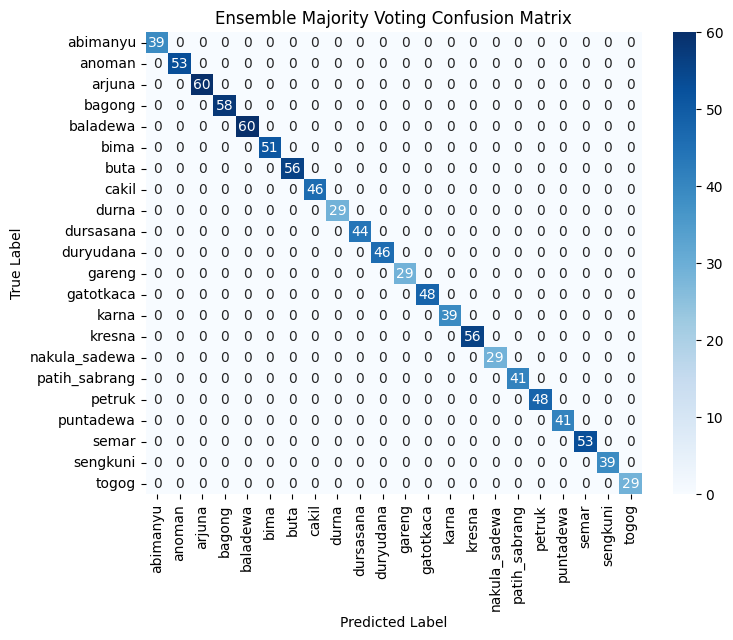

------------------------------


In [60]:
print("--- Evaluating Ensemble Performance (Majority Voting) ---")

max_class_index = max(test_generator.class_indices.values())

true_test_labels = test_generator.classes

predicted_classes_by_model = [np.argmax(p, axis=1) for p in predictions_list]

stacked_predictions = np.stack(predicted_classes_by_model, axis=1)

final_ensemble_predictions, _ = mode(stacked_predictions, axis=1, keepdims=False)

# Ensure the result is a 1D array (mode might return 2D if all values are the same)
if final_ensemble_predictions.ndim > 1:
    final_ensemble_predictions = final_ensemble_predictions.flatten()

print(f"Final ensemble predictions shape after voting: {final_ensemble_predictions.shape}")

print("\n--- Majority Voting Complete ---")
# Create a list to hold class names, initially None
class_names = [None] * (max_class_index + 1)
# Fill the list using the class_indices dictionary
for name, index in test_generator.class_indices.items():
    class_names[index] = name

print("\nClassification Report:")
# target_names argument makes the output much more readable.
print(classification_report(true_test_labels, final_ensemble_predictions, target_names=class_names))

# 2. Generate and Plot Confusion Matrix
print("\nGenerating Confusion Matrix...")
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_test_labels, final_ensemble_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Ensemble Majority Voting Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()